In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [ ]:
def preprocess(pixels):
  images = []
  for i in range(len(pixels)):
    img = np.fromstring(pixels[i], dtype='float32', sep=' ')
    img = img / 255.0
    img = img.reshape(48,48,1)
    images.append(img)
  return images


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/icml_face_data.csv')
sample_subset = [3,4,0]
train = df.groupby(' Usage').get_group('Training')
train = train.loc[train['emotion'].isin(sample_subset)]
print(train.emotion.value_counts())
x_train = np.array(preprocess(train[' pixels'].to_numpy()))
y_train = np.array(train['emotion'])
y_dict = {3:0, 4:1, 0:2}
y_train = np.array([y_dict[value] for value in y_train])


testing = df.groupby(' Usage').get_group('PublicTest')
testing = testing.append(df.groupby(' Usage').get_group('PrivateTest'))
testing = testing.loc[testing['emotion'].isin(sample_subset)]
print(testing.emotion.value_counts())
x_test = np.array(preprocess(testing[' pixels'].to_numpy()))
y_test = np.array(testing['emotion'])
y_test = np.array([y_dict[value] for value in y_test])


3    7215
4    4830
0    3995
Name: emotion, dtype: int64
3    1774
4    1247
0     958
Name: emotion, dtype: int64


In [ ]:
def create_model():
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='valid'))
  # model.add(tf.keras.layers.BatchNormalization(axis=3))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(.3))
 
  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  # model.add(tf.keras.layers.BatchNormalization(axis=3))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(.3))


  model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', strides=(1,1), padding='valid'))
  # model.add(tf.keras.layers.BatchNormalization(axis=3))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  # model.add(tf.keras.layers.BatchNormalization(axis=3))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(.3))

  model.add(tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  # model.add(tf.keras.layers.BatchNormalization(axis=3))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(.3))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(300, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(3, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0003), metrics=['accuracy'])

  return model  

In [ ]:
def create_model_2():
  model = tf.keras.models.Sequential()
  #model.add(base_model)
  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='elu', padding='same', input_shape=(48,48,1), data_format='channels_last'))
  model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding = 'same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding = 'same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding = 'same'))
  model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding = 'same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding = 'same'))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1024, activation='elu'))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Dense(3, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0003), metrics=['accuracy'])
  return model

In [ ]:
def create_model_1():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  # model.add(tf.keras.layers.BatchNormalization(axis=3))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  # model.add(tf.keras.layers.BatchNormalization(axis=3))

  model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  # model.add(tf.keras.layers.BatchNormalization(axis=3))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  # model.add(tf.keras.layers.BatchNormalization(axis=3))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  model.add(tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  model.add(tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  # model.add(tf.keras.layers.BatchNormalization(axis=3))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)))
  model.add(tf.keras.layers.Dense(3, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])
  
  return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
502/502 [==============================] - 5s 8ms/step - loss: 1.0670 - accuracy: 0.4493 - val_loss: 1.0676 - val_accuracy: 0.4458
Epoch 2/50
502/502 [==============================] - 4s 7ms/step - loss: 1.0394 - accuracy: 0.4737 - val_loss: 1.0137 - val_accuracy: 0.5004
Epoch 3/50
502/502 [==============================] - 4s 7ms/step - loss: 0.9491 - accuracy: 0.5438 - val_loss: 0.8807 - val_accuracy: 0.5783
Epoch 4/50
502/502 [==============================] - 4s 7ms/step - loss: 0.8554 - accuracy: 0.6002 - val_loss: 0.7964 - val_accuracy: 0.6346
Epoch 5/50
502/502 [==============================] - 4s 8ms/step - loss: 0.7989 - accuracy: 0.6299 - val_loss: 0.7287 - val_accuracy: 0.6723
Epoch 6/50
502/502 [==============================] - 4s 7ms/step - loss: 0.7504 - accuracy: 0.6571 - val_loss: 0.7033 - val_accuracy: 0.6884
Epoch 7/50
502/502 [==============================] - 4s 8ms/step - loss: 0.7175 - accuracy: 0.6762 - val_loss: 0.6671 - val_accuracy: 0.7024
Epoch 

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Happy


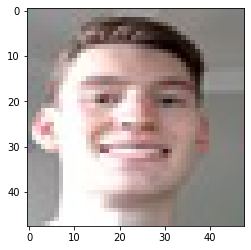

Angry


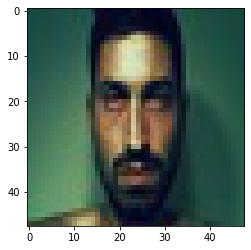

Angry


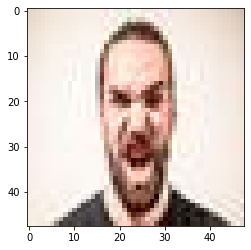

Happy


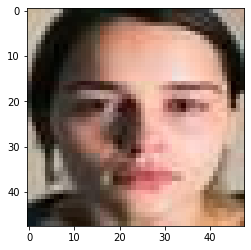

Sad


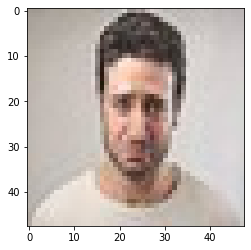

In [ ]:
def main():
  model = create_model()
  callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
  model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), shuffle=True, callbacks=[callback])
  model.save('/content/drive/MyDrive/model.h5')
  imghappy = tf.keras.utils.load_img('/content/drive/MyDrive/happy (1).jpg', grayscale=True, target_size=(48,48))
  imgsad = tf.keras.utils.load_img('/content/drive/MyDrive/sa3 (1) (1).jpeg', grayscale=True, target_size=(48,48))
  imgsad2 = tf.keras.utils.load_img('/content/drive/MyDrive/sad4 (1) (1).jpeg', grayscale=True, target_size=(48,48))
  imgsad3 = tf.keras.utils.load_img('/content/drive/MyDrive/sad2 (1) (1).jpeg', grayscale=True, target_size=(48,48))
  imgneutral = tf.keras.utils.load_img('/content/drive/MyDrive/angry (1) (1).jpeg', grayscale=True, target_size=(48,48))
  label_dict = {0 : 'Happy', 1 : 'Sad', 2 : 'Angry'}

  happy = tf.keras.utils.img_to_array(imghappy)
  happy = happy / 255.0
  happy = np.expand_dims(happy, axis=0)
  prediction = np.argmax(model.predict(happy))
  print(label_dict[prediction])
  img = mpimg.imread('/content/drive/MyDrive/happy (1).jpg')
  imgplot = plt.imshow(img)
  plt.show()

  sad = tf.keras.utils.img_to_array(imgsad)
  sad = sad / 255.0
  sad = np.expand_dims(sad, axis=0)
  prediction = np.argmax(model.predict(sad))
  print(label_dict[prediction])
  img = mpimg.imread('/content/drive/MyDrive/sa3 (1) (1).jpeg')
  imgplot = plt.imshow(img)
  plt.show()
  
  neutral = tf.keras.utils.img_to_array(imgneutral)
  neutral = neutral / 255.0
  neutral = np.expand_dims(neutral, axis=0)
  prediction = np.argmax(model.predict(neutral))
  print(label_dict[prediction])
  img = mpimg.imread('/content/drive/MyDrive/angry (1) (1).jpeg')
  imgplot = plt.imshow(img)
  plt.show()

  sad2 = tf.keras.utils.img_to_array(imgsad2)
  sad2 = sad2/ 255.0
  sad2 = np.expand_dims(sad2, axis=0)
  prediction = np.argmax(model.predict(sad2))
  print(label_dict[prediction])
  img = mpimg.imread('/content/drive/MyDrive/sad4 (1) (1).jpeg')
  imgplot = plt.imshow(img)
  plt.show()

  sad3 = tf.keras.utils.img_to_array(imgsad3)
  sad3 = sad3/ 255.0
  sad3 = np.expand_dims(sad3, axis=0)
  prediction = np.argmax(model.predict(sad3))
  print(label_dict[prediction])
  img = mpimg.imread('/content/drive/MyDrive/sad2 (1) (1).jpeg')
  imgplot = plt.imshow(img)
  plt.show()
main()